In [164]:
%matplotlib inline


[Learn the Basics](intro.html) ||
**Quickstart** ||
[Tensors](tensorqs_tutorial.html) ||
[Datasets & DataLoaders](data_tutorial.html) ||
[Transforms](transforms_tutorial.html) ||
[Build Model](buildmodel_tutorial.html) ||
[Autograd](autogradqs_tutorial.html) ||
[Optimization](optimization_tutorial.html) ||
[Save & Load Model](saveloadrun_tutorial.html)

# Quickstart
This section runs through the API for common tasks in machine learning. Refer to the links in each section to dive deeper.

## Working with data
PyTorch has two [primitives to work with data](https://pytorch.org/docs/stable/data.html):
``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset``.


In [165]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, models
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch import Tensor
import torch.nn.functional as F

from sklearn import metrics
import numpy as np

PyTorch offers domain-specific libraries such as [TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and [TorchAudio](https://pytorch.org/audio/stable/index.html),
all of which include datasets. For this tutorial, we  will be using a TorchVision dataset.

The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision data like
CIFAR, COCO ([full list here](https://pytorch.org/vision/stable/datasets.html)). In this tutorial, we
use the FashionMNIST dataset. Every TorchVision ``Dataset`` includes two arguments: ``transform`` and
``target_transform`` to modify the samples and labels respectively.



In [166]:
# !unzip cat_dog_full.zip

In [167]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

target_transform = transforms.Compose([
    transforms.Lambda(lambda x: float(x))
])

small_training = './cat_dog/train'
small_testing = './cat_dog/test'

full_training = './dataset/training_set'
full_testing = './dataset/test_set'

# train_data = datasets.ImageFolder('./cat_dog/train', transform=transform, target_transform = target_transform)
# test_data = datasets.ImageFolder('./cat_dog/test', transform=transform, target_transform = target_transform)

train_data = datasets.ImageFolder(full_training, transform=transform)
test_data = datasets.ImageFolder(full_testing, transform=transform)





We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element
in the dataloader iterable will return a batch of 64 features and labels.



In [168]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(train_data, batch_size=batch_size, 
                              shuffle=True
                              )
test_dataloader = DataLoader(test_data, batch_size=batch_size)

Read more about [loading data in PyTorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), [downloading other datasets](https://pytorch.org/vision/stable/datasets.html), and [creating your own dataset from folders of images](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder).




--------------




## Creating Models
To define a neural network in PyTorch, we create a class that inherits
from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). We define the layers of the network
in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function. To accelerate
operations in the neural network, we move it to the GPU if available.



In [169]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.convnet = nn.Sequential(
            
            # 1st Conv layer
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3),
                      padding='same', padding_mode='zeros'),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.2),

            # 2nd Conv layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3),
                      padding='same', padding_mode='zeros'),
            nn.ReLU(),           
            nn.MaxPool2d(2,2),
            nn.Dropout(0.2),

            # 3rd Conv layer
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3),
                      padding='same', padding_mode='zeros'),
            nn.ReLU(),           
            nn.MaxPool2d(2,2),
            nn.Dropout(0.2),

            # 4th Conv layer
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3),
                      padding='same', padding_mode='zeros'),
            nn.ReLU(),           
            nn.MaxPool2d(2,2),
            nn.Dropout(0.2),

            # 5th Conv layer
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3),
                      padding='same', padding_mode='zeros'),
            nn.ReLU(),           
            nn.MaxPool2d(2,2),
            nn.Dropout(0.2),

            # Dense layers
            nn.Flatten(),
            nn.Linear(in_features=1024, out_features=64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=64, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        logits = self.convnet(x)
        return logits.flatten()



model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (convnet): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.2, inplace=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.2, inplace=False)
    (16): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (17): Re

Read more about [building neural networks in PyTorch](buildmodel_tutorial.html).




--------------




## Optimizing the Model Parameters
To train a model, we need a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions)
and an [optimizer](https://pytorch.org/docs/stable/optim.html).



In [170]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and
backpropagates the prediction error to adjust the model's parameters.



In [171]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.float().to(device)
        # Compute prediction error
        pred = model(X)
        
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model's performance against the test dataset to ensure it is learning.



In [172]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    y_preds = []
    ys = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.float().to(device)
            pred = model(X)

            y_preds.append(pred)
            ys.append(y)

            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()
    
    # Convert array of predictions and actuals to needed format
    y_preds = np.asarray(torch.cat(y_preds).cpu())
    ys = np.asarray(torch.cat(ys).cpu())

    # Calculate ROC Curve & AUROC
    fpr, tpr, thresholds = metrics.roc_curve(ys, y_preds)
    auroc = metrics.roc_auc_score(ys, y_preds)

    # Plot ROC Curve & print AUROC
    plt.figure(1)
    plt.plot([0,1], [0,1], 'k-')
    plt.plot(fpr, tpr, label='CNN(area={:.3f}'.format(auroc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    print('AUROC:', auroc)

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (*epochs*). During each epoch, the model learns
parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.



Epoch 1
-------------------------------
loss: 0.695749  [    0/ 8000]
loss: 0.669685  [ 6400/ 8000]


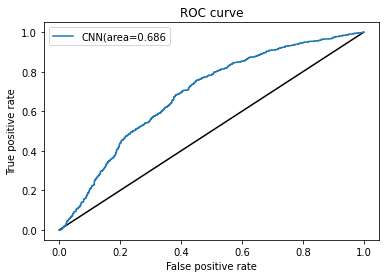

AUROC: 0.6862235
Test Error: 
 Accuracy: 62.1%, Avg loss: 0.673373 

Epoch 2
-------------------------------
loss: 0.683591  [    0/ 8000]
loss: 0.628466  [ 6400/ 8000]


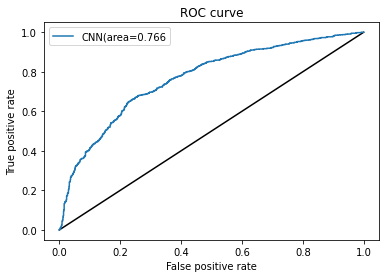

AUROC: 0.7659499999999999
Test Error: 
 Accuracy: 69.9%, Avg loss: 0.601213 

Epoch 3
-------------------------------
loss: 0.613408  [    0/ 8000]
loss: 0.773490  [ 6400/ 8000]


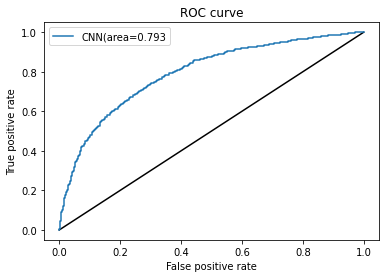

AUROC: 0.7926019999999999
Test Error: 
 Accuracy: 71.9%, Avg loss: 0.555473 

Epoch 4
-------------------------------
loss: 0.556467  [    0/ 8000]
loss: 0.529464  [ 6400/ 8000]


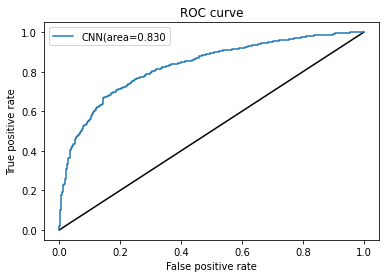

AUROC: 0.829624
Test Error: 
 Accuracy: 75.8%, Avg loss: 0.522406 

Epoch 5
-------------------------------
loss: 0.489926  [    0/ 8000]
loss: 0.491046  [ 6400/ 8000]


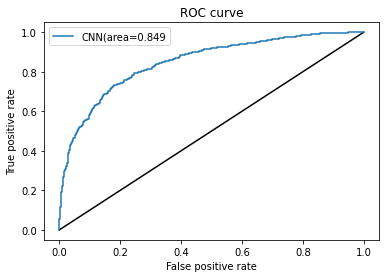

AUROC: 0.8485410000000001
Test Error: 
 Accuracy: 77.1%, Avg loss: 0.490089 

Epoch 6
-------------------------------
loss: 0.554523  [    0/ 8000]
loss: 0.551033  [ 6400/ 8000]


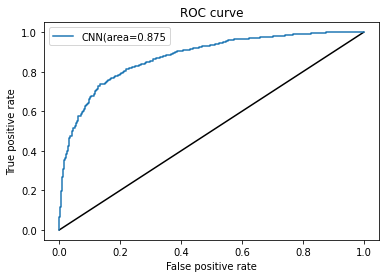

AUROC: 0.8750639999999998
Test Error: 
 Accuracy: 79.4%, Avg loss: 0.448129 

Epoch 7
-------------------------------
loss: 0.322020  [    0/ 8000]
loss: 0.456065  [ 6400/ 8000]


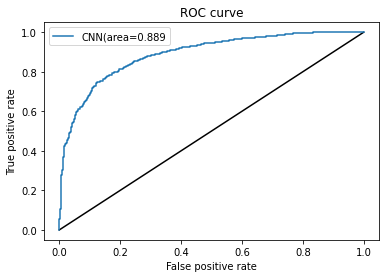

AUROC: 0.888785
Test Error: 
 Accuracy: 79.8%, Avg loss: 0.451979 

Epoch 8
-------------------------------
loss: 0.505099  [    0/ 8000]
loss: 0.403355  [ 6400/ 8000]


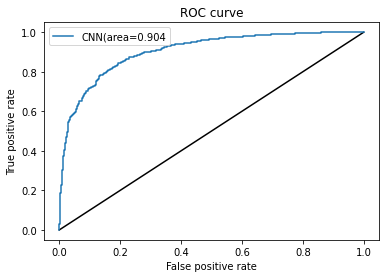

AUROC: 0.904149
Test Error: 
 Accuracy: 82.5%, Avg loss: 0.404705 

Epoch 9
-------------------------------
loss: 0.441887  [    0/ 8000]
loss: 0.469159  [ 6400/ 8000]


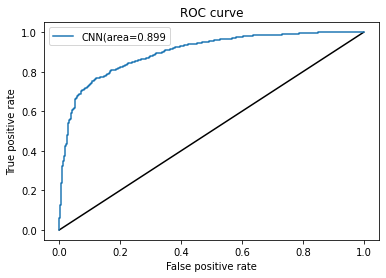

AUROC: 0.8987850000000001
Test Error: 
 Accuracy: 80.5%, Avg loss: 0.424333 

Epoch 10
-------------------------------
loss: 0.437957  [    0/ 8000]
loss: 0.552909  [ 6400/ 8000]


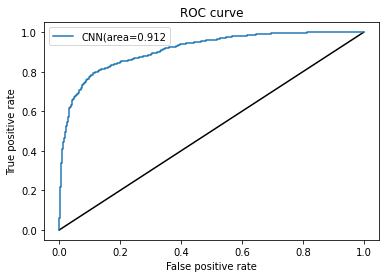

AUROC: 0.9117109999999999
Test Error: 
 Accuracy: 81.2%, Avg loss: 0.445091 

Epoch 11
-------------------------------
loss: 0.429237  [    0/ 8000]
loss: 0.411209  [ 6400/ 8000]


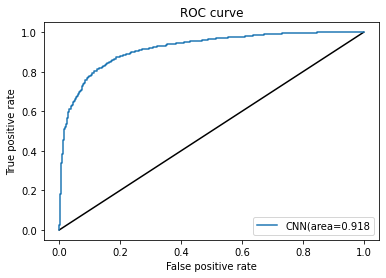

AUROC: 0.918424
Test Error: 
 Accuracy: 84.1%, Avg loss: 0.376979 

Epoch 12
-------------------------------
loss: 0.303804  [    0/ 8000]
loss: 0.292775  [ 6400/ 8000]


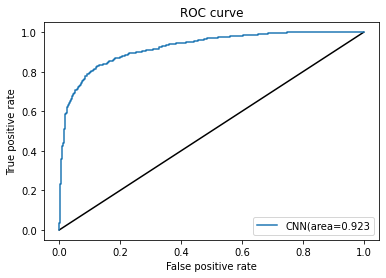

AUROC: 0.922585
Test Error: 
 Accuracy: 84.0%, Avg loss: 0.380621 

Epoch 13
-------------------------------
loss: 0.299938  [    0/ 8000]
loss: 0.380408  [ 6400/ 8000]


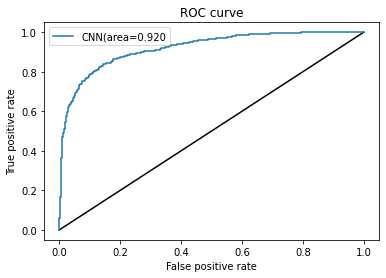

AUROC: 0.919886
Test Error: 
 Accuracy: 81.9%, Avg loss: 0.429739 

Epoch 14
-------------------------------
loss: 0.251850  [    0/ 8000]
loss: 0.239264  [ 6400/ 8000]


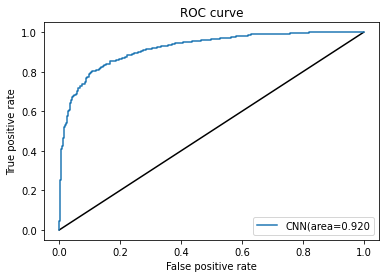

AUROC: 0.9195409999999999
Test Error: 
 Accuracy: 84.0%, Avg loss: 0.378394 

Epoch 15
-------------------------------
loss: 0.230563  [    0/ 8000]
loss: 0.236683  [ 6400/ 8000]


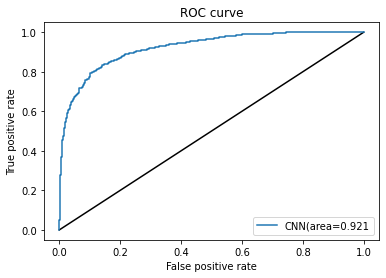

AUROC: 0.9214709999999999
Test Error: 
 Accuracy: 81.3%, Avg loss: 0.432081 

Epoch 16
-------------------------------
loss: 0.282898  [    0/ 8000]
loss: 0.276806  [ 6400/ 8000]


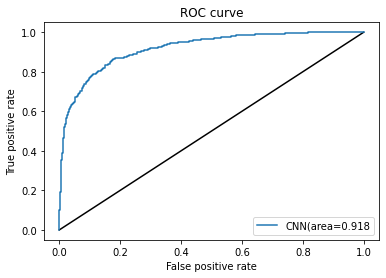

AUROC: 0.9183249999999998
Test Error: 
 Accuracy: 83.0%, Avg loss: 0.434299 

Epoch 17
-------------------------------
loss: 0.258520  [    0/ 8000]
loss: 0.370431  [ 6400/ 8000]


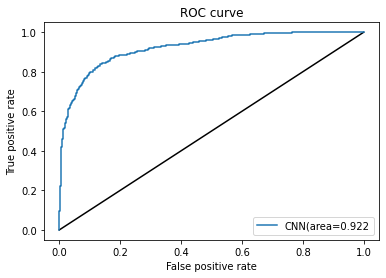

AUROC: 0.922338
Test Error: 
 Accuracy: 84.9%, Avg loss: 0.363558 

Epoch 18
-------------------------------
loss: 0.196104  [    0/ 8000]
loss: 0.339414  [ 6400/ 8000]


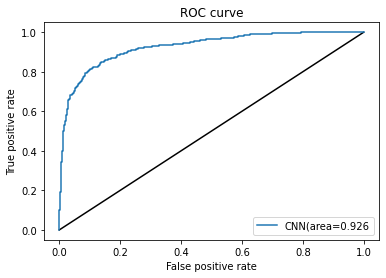

AUROC: 0.9261959999999999
Test Error: 
 Accuracy: 83.5%, Avg loss: 0.399353 

Epoch 19
-------------------------------
loss: 0.287593  [    0/ 8000]
loss: 0.346417  [ 6400/ 8000]


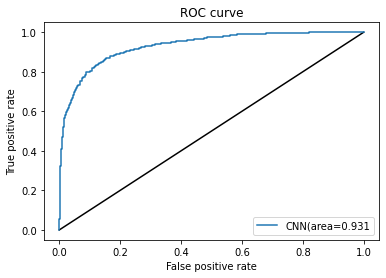

AUROC: 0.9309059999999999
Test Error: 
 Accuracy: 85.0%, Avg loss: 0.358617 

Epoch 20
-------------------------------
loss: 0.321821  [    0/ 8000]
loss: 0.342305  [ 6400/ 8000]


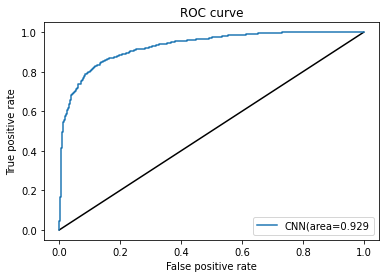

AUROC: 0.9289919999999999
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.375779 

Epoch 21
-------------------------------
loss: 0.394846  [    0/ 8000]
loss: 0.301281  [ 6400/ 8000]


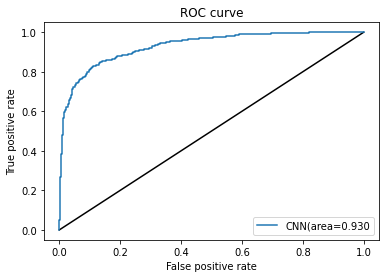

AUROC: 0.9299109999999999
Test Error: 
 Accuracy: 83.5%, Avg loss: 0.379919 

Epoch 22
-------------------------------
loss: 0.467664  [    0/ 8000]
loss: 0.246830  [ 6400/ 8000]


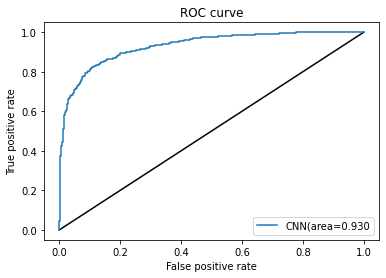

AUROC: 0.930153
Test Error: 
 Accuracy: 85.5%, Avg loss: 0.365529 

Epoch 23
-------------------------------
loss: 0.165910  [    0/ 8000]
loss: 0.211337  [ 6400/ 8000]


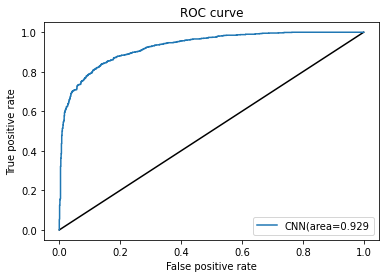

AUROC: 0.9285315
Test Error: 
 Accuracy: 84.8%, Avg loss: 0.395402 

Epoch 24
-------------------------------
loss: 0.103549  [    0/ 8000]
loss: 0.203126  [ 6400/ 8000]


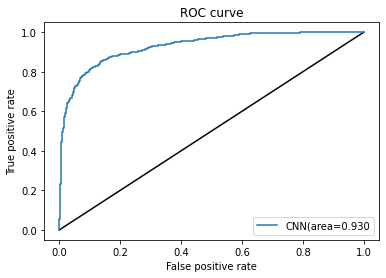

AUROC: 0.929986
Test Error: 
 Accuracy: 84.0%, Avg loss: 0.447947 

Epoch 25
-------------------------------
loss: 0.163515  [    0/ 8000]
loss: 0.235921  [ 6400/ 8000]


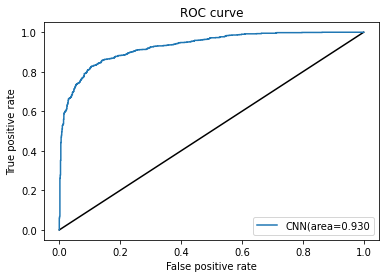

AUROC: 0.9295415
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.438584 

Epoch 26
-------------------------------
loss: 0.145310  [    0/ 8000]
loss: 0.154858  [ 6400/ 8000]


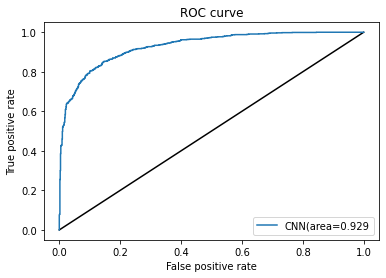

AUROC: 0.9293355
Test Error: 
 Accuracy: 84.9%, Avg loss: 0.389490 

Epoch 27
-------------------------------
loss: 0.190718  [    0/ 8000]
loss: 0.113608  [ 6400/ 8000]


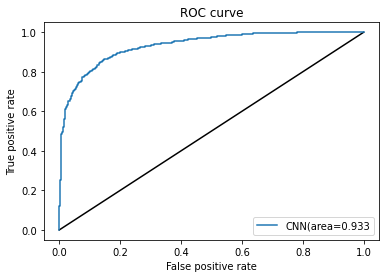

AUROC: 0.932698
Test Error: 
 Accuracy: 85.7%, Avg loss: 0.371837 

Epoch 28
-------------------------------
loss: 0.214848  [    0/ 8000]
loss: 0.180096  [ 6400/ 8000]


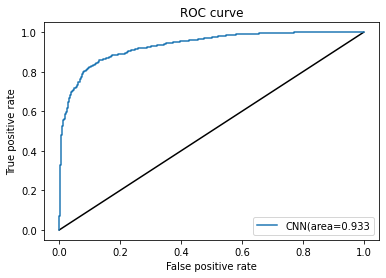

AUROC: 0.9326399999999999
Test Error: 
 Accuracy: 86.1%, Avg loss: 0.381698 

Epoch 29
-------------------------------
loss: 0.241672  [    0/ 8000]
loss: 0.122291  [ 6400/ 8000]


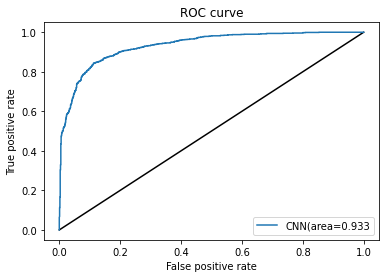

AUROC: 0.93261
Test Error: 
 Accuracy: 86.1%, Avg loss: 0.391498 

Epoch 30
-------------------------------
loss: 0.108122  [    0/ 8000]
loss: 0.124501  [ 6400/ 8000]


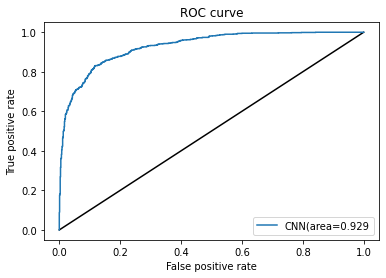

AUROC: 0.9291179999999999
Test Error: 
 Accuracy: 85.2%, Avg loss: 0.400098 

Epoch 31
-------------------------------
loss: 0.113854  [    0/ 8000]
loss: 0.165429  [ 6400/ 8000]


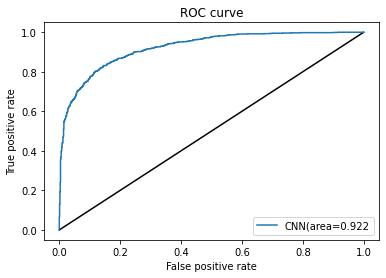

AUROC: 0.9222375
Test Error: 
 Accuracy: 83.1%, Avg loss: 0.485578 

Epoch 32
-------------------------------
loss: 0.215562  [    0/ 8000]
loss: 0.237832  [ 6400/ 8000]


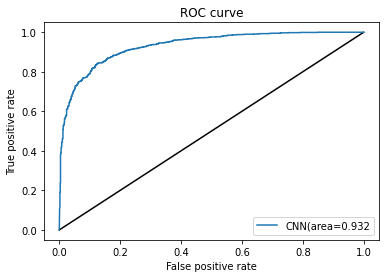

AUROC: 0.9317660000000001
Test Error: 
 Accuracy: 84.9%, Avg loss: 0.466199 

Epoch 33
-------------------------------
loss: 0.190074  [    0/ 8000]
loss: 0.158939  [ 6400/ 8000]


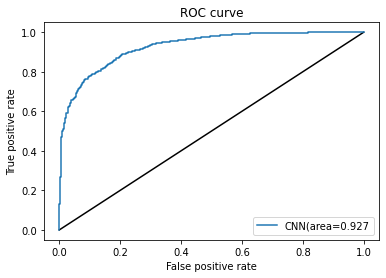

AUROC: 0.92714
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.425058 

Epoch 34
-------------------------------
loss: 0.224167  [    0/ 8000]
loss: 0.320336  [ 6400/ 8000]


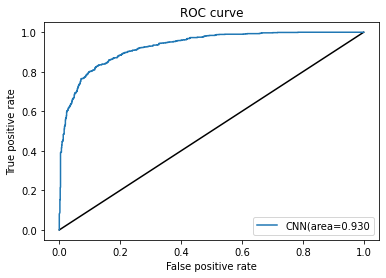

AUROC: 0.9299345
Test Error: 
 Accuracy: 84.7%, Avg loss: 0.480657 

Epoch 35
-------------------------------
loss: 0.084729  [    0/ 8000]
loss: 0.191249  [ 6400/ 8000]


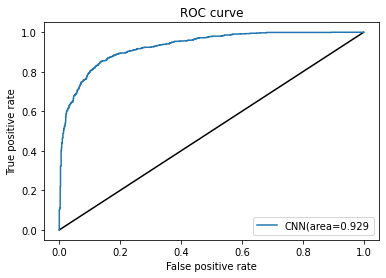

AUROC: 0.9291175
Test Error: 
 Accuracy: 85.2%, Avg loss: 0.438128 

Epoch 36
-------------------------------
loss: 0.112602  [    0/ 8000]
loss: 0.176257  [ 6400/ 8000]


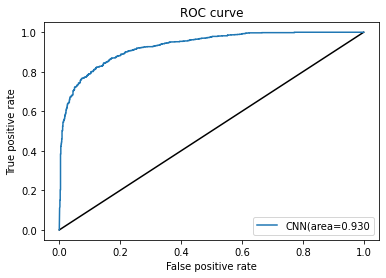

AUROC: 0.930404
Test Error: 
 Accuracy: 84.5%, Avg loss: 0.560463 

Epoch 37
-------------------------------
loss: 0.072298  [    0/ 8000]
loss: 0.186612  [ 6400/ 8000]


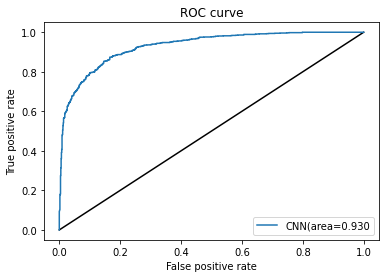

AUROC: 0.9295945
Test Error: 
 Accuracy: 84.5%, Avg loss: 0.442708 

Epoch 38
-------------------------------
loss: 0.091104  [    0/ 8000]
loss: 0.258185  [ 6400/ 8000]


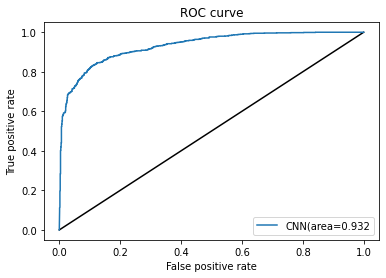

AUROC: 0.9321739999999998
Test Error: 
 Accuracy: 84.9%, Avg loss: 0.535493 

Epoch 39
-------------------------------
loss: 0.045868  [    0/ 8000]
loss: 0.139914  [ 6400/ 8000]


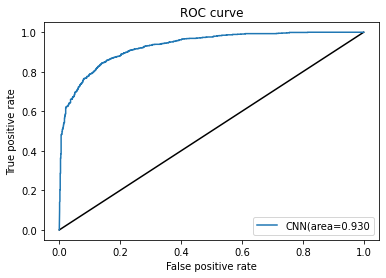

AUROC: 0.930182
Test Error: 
 Accuracy: 84.1%, Avg loss: 0.529911 

Epoch 40
-------------------------------
loss: 0.088652  [    0/ 8000]
loss: 0.149342  [ 6400/ 8000]


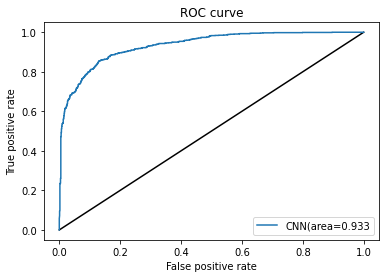

AUROC: 0.9334705
Test Error: 
 Accuracy: 85.0%, Avg loss: 0.433626 

Done!


In [173]:
epochs = 40
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Read more about [Training your model](optimization_tutorial.html).




--------------




## Saving Models
A common way to save a model is to serialize the internal state dictionary (containing the model parameters).



In [174]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Loading Models

The process for loading a model includes re-creating the model structure and loading
the state dictionary into it.



In [175]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

This model can now be used to make predictions.



In [176]:
# classes = [
#     "T-shirt/top",
#     "Trouser",
#     "Pullover",
#     "Dress",
#     "Coat",
#     "Sandal",
#     "Shirt",
#     "Sneaker",
#     "Bag",
#     "Ankle boot",
# ]

# model.eval()
# x, y = test_data[0][0], test_data[0][1]
# with torch.no_grad():
#     pred = model(x)
#     predicted, actual = classes[pred[0].argmax(0)], classes[y]
#     print(f'Predicted: "{predicted}", Actual: "{actual}"')

Read more about [Saving & Loading your model](saveloadrun_tutorial.html).


